# Quadruped [Gait](https://en.wikipedia.org/wiki/Gait)

---

Kevin Walchko, created 8 Nov 2016



In [1]:
%matplotlib inline

In [48]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm 
from math import sin, cos, pi, sqrt
from math import radians as d2r

## Hildebrand Diagram

Example diagram from wikipedia:

![](http://i.giphy.com/11kXFNRcZBFgwo.gif)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Gait_graphs.jpg/800px-Gait_graphs.jpg)

$\phi$ is the phase of each leg and $z$ is the foot height. The black bars indicate when a foot is in contact with the ground.

Common gaits for quadrupeds (spider/crab configuration):

* **Ripple Gait:** when one leg is in the air while the other three are holding up the body. This tends to be a stable gait when you keep the center of mass (CM) inside the triangle formed by the three legs in contact with the ground. Becuase of the stability, you could interrupt this gait at any time (i.e., stop it) and the robot will not fall over.

* **Trott Gait:** A fast gait where two legs are in the air moving while the other two legs are in contact with the ground. This is an unstable gait and the robot could fall over if the gait is not executed quickly enough.

Terminology:

* **Duty Factor:** Duty factor is simply the percent of the total cycle which a given foot is on the ground. Duty factors over 50% are considered a "walk", while those less than 50% are considered a run. 

* **Forelimb-hindlimb Phase (or just Phase):** is the temporal relationship between the limb pairs.

In [3]:
def printFoot(i, newpos):
    if i == 0:
        print('New [{}](x,y,z): {:.2f}\t{:.2f}\t{:.2f}'.format(i, newpos[0], newpos[1], newpos[2]))

def rot_z(t, c):
    """
    t - theta [radians]
    c - [x,y,z] or [x,y] ... the function detects 2D or 3D vector
    """
    if len(c) == 3:
        ans = np.array([
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t),
            c[2]
        ])
    else:
        ans = np.array([
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t)
        ])

    return ans

In [4]:
print('{:.2f} {:.2f} {:.2f}'.format(*rot_z(pi/4, np.array([84,0,-65]))))

59.40 59.40 -65.00


In [5]:
class Gait(object):
    def __init__(self):
        self.legOffset = [0, 6, 3, 9]
#         self.body = np.array([72.12, 0, 0])
        self.rest = None
        
    def calcRotatedOffset(self, cmd, frame_angle):
        """
        calculate the foot offsets for each leg and delta linear/rotational
        in - cmd(x,y,z_rotation)
        out - array(leg0, leg1, ...)
            where leg0 = {'linear': [x,y], 'rotational': [x,y], 'angle': zrotation(rads)}
        """
        # I could do the same here as I do below for rotation
        # rotate the command into the leg frame
        rc = rot_z(frame_angle, cmd)

        # get rotation distance: dist = rot_z(angle, rest) - rest
        # this just reduces the function calls and math
        zrot = d2r(float(cmd[2]))  # should I assume this is always radians? save conversion

#         fromcenter = self.rest + self.body

        # value of this?
#         rot = rot_z(zrot/2, fromcenter) - rot_z(-zrot/2, fromcenter)

#         ans = {'linear': rc, 'rotational': rot, 'angle': zrot}
        ans = {'linear': rc, 'angle': zrot}

        return ans
    
    def command(self, cmd, func, steps=12):
        # handle no movement command ... do else where?
        if sqrt(cmd[0]**2 + cmd[1]**2 + cmd[2]**2) < 0.001:
            for leg in range(0, 4):
                func(leg, self.rest)  # move to resting position
            return

        cmd = [100.0, 0.0, 0.0]
        
        # frame rotations for each leg
        frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]

        for i in range(0, steps):  # iteration, there are 12 steps in gait cycle
            for legNum in [0, 2, 1, 3]:  # order them diagonally
                rcmd = self.calcRotatedOffset(cmd, frame[legNum])
                pos = self.eachLeg(i, rcmd)  # move each leg appropriately
                func(legNum, pos)

## Discrete Ripple Gait

The gait uses an array to hold the leg/foot positions in an attempt to simplify the coding and reduce the computational requirements.

In [6]:
class DiscreteRippleGait(Gait):
    def __init__(self, h, r):
        Gait.__init__(self)
        self.phi = [9/9, 6/9, 3/9, 0/9, 1/9, 2/9, 3/9, 4/9, 5/9, 6/9, 7/9, 8/9]  # foot pos in gait sequence
        maxl = h  #
        minl = maxl/2
        self.z = [minl, maxl, maxl, minl, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # leg height
        self.rest = r # idle leg position

    def eachLeg(self, index, cmd):
        """
        interpolates the foot position of each leg
        cmd:
            linear (mm)
            angle (rads)
        """
        rest = self.rest
        i = index % 12
        phi = self.phi[i]

        # rotational commands -----------------------------------------------
        angle = cmd['angle']/2-cmd['angle']*phi
        rest_rot = rot_z(-angle, rest)

        # linear commands ----------------------------------------------------
        linear = cmd['linear']
        xx = linear[0]
        yy = linear[1]

        # create new move command
        move = np.array([
            xx/2 - phi*xx,
            yy/2 - phi*yy,
            self.z[i]
        ])

        # new foot position: newpos = rest + move ----------------------------
        newpos = move + rest_rot
        return newpos

## Continous Ripple Gait

Unlike the discrete gait above, this continous gait can be interpolated into finer steps in an attempt to slow down the speed of the gait or produce smoother movements.

In [7]:
class ContinousRippleGait(Gait):
    alpha = 0.5
    
    def __init__(self, h, r):
        Gait.__init__(self)
        self.height = h
        self.rest = r
    
    def phi(self, x):
        """
        The phase 
        """
        phi = 0.0
        if x <= 3.0:
            phi = 1/3*(3.0-x)
        else:
            phi = 1/9*(x-3)
        return phi

    def z(self, x):
        """
        Leg height

        duty cycle:
            0-3: leg lifted
            3-12: leg on ground
            duty = (12-3)/12 = 0.75 = 75% a walking gait
        """
        height = self.height
        z = 0.0
        if x <= 1:
            z = height/1.0*x
        elif x <= 2.0:
            z = height
        elif x <= 3.0:
            z = -height/1.0*(x-2.0)+height
        return z

    def eachLeg(self, index, cmd):
        """
        interpolates the foot position of each leg
        """
        rest = self.rest
        i = (index*self.alpha) % 12
        phi = self.phi(i)
        z = self.z(i)

        # rotational commands -----------------------------------------------
        angle = cmd['angle']/2-cmd['angle']*phi
        rest_rot = rot_z(-angle, rest)

        # linear commands ----------------------------------------------------
        linear = cmd['linear']
        xx = linear[0]
        yy = linear[1]

        # create new move command
        move = np.array([
            xx/2 - phi*xx,
            yy/2 - phi*yy,
            z
        ])

        # new foot position: newpos = rest + move ----------------------------
        newpos = move + rest_rot
        return newpos

## Gait Plot

Now select which gait you want and run it for just one leg. In reality you would need to do this for all 4 legs.

In [94]:
cmd = {'linear': [0,0], 'angle': pi/4}
leg = np.array([84,0.0,-65]) # idle leg position
height = 25

# gait = ContinousRippleGait(height, leg)
gait = DiscreteRippleGait(height, leg)
alpha = 1
pos = []
for i in range(0,12):
    p = gait.eachLeg(i*alpha,cmd)
    pos.append(p)
    print(p)

[ 77.60588073  32.14540832 -52.5       ]
[ 83.28136836  10.96420015 -40.        ]
[ 83.28136836 -10.96420015 -40.        ]
[ 77.60588073 -32.14540832 -52.5       ]
[ 80.11222386 -25.25928716 -65.        ]
[ 82.0088646  -18.18092757 -65.        ]
[ 83.28136836 -10.96420015 -65.        ]
[ 83.92005061  -3.66402854 -65.        ]
[ 83.92005061   3.66402854 -65.        ]
[ 83.28136836  10.96420015 -65.        ]
[ 82.0088646   18.18092757 -65.        ]
[ 80.11222386  25.25928716 -65.        ]


Now the code below runs the for all 4 legs and only prints out the position for leg 0. You can modify this above in the `printFoot` function. In reality, you would pass a function to move the leg. 

In [8]:
# Run the entire class
# remember!! command does a rotation of the leg coord system, so it
# will output different numbers than above.
cmd = [0,0,pi/4]
leg = np.array([84,0.0,-65]) # idle leg position
height = 25

# gait = ContinousRippleGait(height, leg)
# gait.alpha = 0.5
gait = DiscreteRippleGait(height, leg)
gait.command(cmd, printFoot, steps=12)  # doesn't return anything

New [0](x,y,z): 48.64	35.36	-52.50
New [0](x,y,z): 72.21	11.79	-40.00
New [0](x,y,z): 95.79	-11.79	-40.00
New [0](x,y,z): 119.36	-35.36	-52.50
New [0](x,y,z): 111.50	-27.50	-65.00
New [0](x,y,z): 103.64	-19.64	-65.00
New [0](x,y,z): 95.79	-11.79	-65.00
New [0](x,y,z): 87.93	-3.93	-65.00
New [0](x,y,z): 80.07	3.93	-65.00
New [0](x,y,z): 72.21	11.79	-65.00
New [0](x,y,z): 64.36	19.64	-65.00
New [0](x,y,z): 56.50	27.50	-65.00


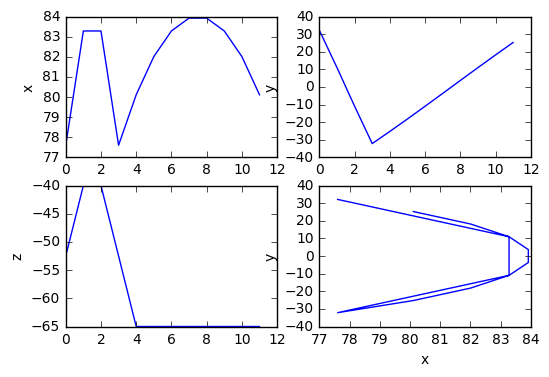

In [96]:
px = []
py = []
pz = []
for p in pos:
    px.append(p[0])
    py.append(p[1])
    pz.append(p[2])

plt.subplot(2,2,1);
plt.plot(px)
plt.ylabel('x')

plt.subplot(2,2,2)
plt.plot(py)
plt.ylabel('y')

plt.subplot(2,2,3);
plt.plot(pz)
plt.ylabel('z')

plt.subplot(2,2,4);
plt.plot(px,py)
plt.ylabel('y')
plt.xlabel('x');

In [93]:
for p in pos:
    print(p)

[ 77.60588073 -32.14540832 -52.5       ]
[ 83.28136836 -10.96420015 -40.        ]
[ 83.28136836  10.96420015 -40.        ]
[ 77.60588073  32.14540832 -52.5       ]
[ 80.11222386  25.25928716 -65.        ]
[ 82.0088646   18.18092757 -65.        ]
[ 83.28136836  10.96420015 -65.        ]
[ 83.92005061   3.66402854 -65.        ]
[ 83.92005061  -3.66402854 -65.        ]
[ 83.28136836 -10.96420015 -65.        ]
[ 82.0088646  -18.18092757 -65.        ]
[ 80.11222386 -25.25928716 -65.        ]


In [72]:
def inSideCM(pts):
    """
    Determine if a point P is inside of a triangle composed of points
    A, B, and C.
    pts = [A,B,C]
    P = [0,0] at the center of mass of the robot
    returns True (inside triangle) or False (outside the triangle)
    """
    A = pts[0]
    B = pts[1]
    C = pts[2]
    P = np.array([0,0])  # CM is at the center :)
    
    # Compute vectors        
    v0 = C - A
    v1 = B - A
    v2 = P - A

    # Compute dot products
    dot00 = np.dot(v0, v0)
    dot01 = np.dot(v0, v1)
    dot02 = np.dot(v0, v2)
    dot11 = np.dot(v1, v1)
    dot12 = np.dot(v1, v2)

    # Compute barycentric coordinates
    invDenom = 1 / (dot00 * dot11 - dot01 * dot01)
    u = (dot11 * dot02 - dot01 * dot12) * invDenom
    v = (dot00 * dot12 - dot01 * dot02) * invDenom

    # Check if point is in triangle
    return (u >= 0) and (v >= 0) and (u + v < 1)

def lineIntersection(p1,p2,p3,p4):
    """
    Find the intersection of 2 lines.
    line 1: p1, p2
    line 2: p3, p4
    """
    x1 = p1[0]
    x2 = p2[0]
    x3 = p3[0]
    x4 = p4[0]
    y1 = p1[1]
    y2 = p2[1]
    y3 = p3[1]
    y4 = p4[1]
    
    denom = ((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
    if abs(denom) < 0.00001:
        # print('crap {}'.format(denom))
        return np.array([0,0])
    x = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))/denom
    y = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))/denom
    return np.array([x, y])

def min(a):
    """
    Find the minimum vector in an array of 2D vectors.
    in = [[1,2], [2,3], ...]
    out = [1,2]
    """
    minv = 0
    min_val = 1000000000000000
    for p in a:
        val = norm(p)
        if val < min_val:
            min_val = val
            minv = p
    return minv

def checkCM(pts):
    """
    Given the robot's foot locations, provide correction if the 
    center of mass (CM) is outside the triangle formed by the 3
    foot locations.
    pts = [foot0, foot1, foot2]
    correction = [x,y]
    """
    correction = np.array([0,0])

    if not inSideCM(pts):
        a = []
        for i in range(0, 3):
            p0 = pts[i]
            p1 = pts[(i+1) % 3]
            x1 = 50
            x0 = -50
            cm1 = np.array([x1, -(p1[0] - p0[0])/(p1[1] - p0[1])*x1])
            cm0 = np.array([x0, -(p1[0] - p0[0])/(p1[1] - p0[1])*x0])
            xx = lineIntersection(p0,p1,cm0,cm1)
            a.append(xx)
        a = min(a)
        correction = -a
    return correction

cm = 45*cos(pi/4)

offset = [
    np.array([cm, cm]),
    np.array([cm, -cm]),
    np.array([-cm, -cm]),
    np.array([-cm, cm])
]

pts = [
    np.array([30,60]) + offset[0],    # 0
    np.array([40,-25]) + offset[1],   # 1
    np.array([-31, 61]) + offset[3]   # 3
]

corr = checkCM(pts)
print(corr)

[-11.43680785 -10.29037264]


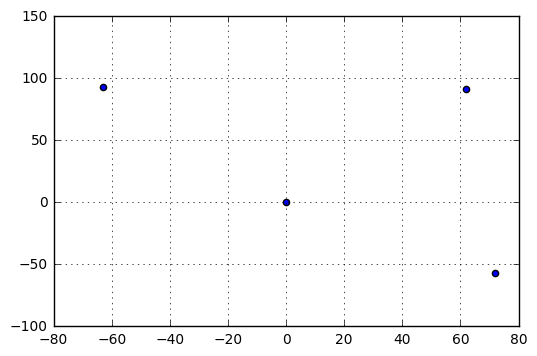

In [71]:
px = []
py = []
# pz = []
for p in pts:
    px.append(p[0])
    py.append(p[1])
#     pz.append(p[2])
px.append(0)
py.append(0)

# plt.subplot(2,2,1);
plt.scatter(px, py)
plt.grid(True)
# plt.ylabel('x')

In [60]:
a=[[-1,1], [-2,3]]
print(pts)
min = 0
min_val = 1000000000000000
for p in pts:
    val = norm(p)
    if val < min_val:
        min = p
print(min)

[array([ 61.81980515,  91.81980515]), array([ 71.81980515, -56.81980515]), array([-62.81980515,  92.81980515])]
[-62.81980515  92.81980515]


In [64]:
print(abs(np.linalg.norm([11.4368078486307, 10.290372640882252])))
print(abs(np.linalg.norm([0.74061408982293475, 92.309851543248016])))

15.3848088339
92.3128225176



-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.